# Importing Libraries

In [2]:
# importing all important libraries

import math
import keras
import numpy as np
import pandas as pd
from keras import layers
from keras.models import Functional
from keras.saving.saving_api import load_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard
import absl.logging
from keras.initializers.initializers import RandomUniform
from keras.constraints import NonNeg
from sklearn.metrics import roc_curve, precision_recall_curve
absl.logging.set_verbosity(absl.logging.ERROR)

In [3]:
# Reading all 4 datasets and combinng them into 1

df = []
for i in range(1, 5):
    temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
    if len(df) == 0:
        df = temp
    else:
        df = pd.concat([df, temp])


<ipython-input-3-7cabe7a72fe5>:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
<ipython-input-3-7cabe7a72fe5>:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
<ipython-input-3-7cabe7a72fe5>:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')
<ipython-input-3-7cabe7a72fe5>:5: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f'UNSW_2018_IoT_Botnet_Full5pc_{i}.csv')


In [4]:
# Getting count of attack column's labels
df['attack'].value_counts()

1    3668045
0        477
Name: attack, dtype: int64

## Variables

In [5]:
# Segregating columns based on thier types

columns = df.columns.tolist()

# categorical columns
nominal = [col for col in columns if df[col].dtype == 'object']

# ordinal columns
discrete = [col for col in columns if df[col].dtype == 'int64']

# continuous columns
continuous = [col for col in columns if df[col].dtype == 'float']

# dissect the dataframe by column types
df_nominal = df.select_dtypes(include=['object'])
df_discrete = df.select_dtypes(include=['int64'])
df_continuous = df.select_dtypes(include=['float'])

# enumerate nominal categories using integers
df_categorical = df.select_dtypes(include=['int8', 'int16'])

# Making a sample of balanced subset data to use it later if required
df_class_0 = df[df['attack'] == 0]
df_class_1 = df[df['attack'] == 1]
df_class_1_subset = df_class_1.sample(n=447, random_state=100)
df_balanced = pd.concat([df_class_1_subset, df_class_0])

## Explore

In [7]:
# print(df.info())
# print(df_class_1.shape)
# print(df_class_0.shape)
# print(df_class_1_subset.shape)
# print(df_balanced.shape)

In [8]:
# for col in df:
#     print(df[col].value_counts(), '\n')

## Transform Data

### Enumerate nominal columns

In [6]:
le = LabelEncoder()
for _col in nominal:
    print(f'before enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')
    try:
        df[_col] = le.fit_transform(df[_col])
    except TypeError:
        df[_col] = le.fit_transform(df[_col].astype(str))
    print(f'after enumerating: {_col}', df[_col].value_counts(), '\n', sep='\n')

before enumerating: flgs
e        2293445
e s      1245171
e g        94344
eU         34599
e *          816
e d          137
e &            5
e   t          4
e  D           1
Name: flgs, dtype: int64


after enumerating: flgs
0    2293445
7    1245171
6      94344
8      34599
4        816
5        137
3          5
1          4
2          1
Name: flgs, dtype: int64


before enumerating: proto
udp          1996437
tcp          1662812
icmp            9052
arp              213
ipv6-icmp          8
Name: proto, dtype: int64


after enumerating: proto
4    1996437
3    1662812
1       9052
0        213
2          8
Name: proto, dtype: int64


before enumerating: saddr
192.168.100.147              950966
192.168.100.148              923290
192.168.100.150              890262
192.168.100.149              890146
192.168.100.3                  8281
192.168.100.5                  5118
192.168.100.6                   327
192.168.100.7                    43
192.168.100.4                    19


In [7]:
# Correlation matrix is used to find the correlation between the columns and attack column
## correlation score of 1.0 means that the column is highly (perfectly) correlated with the subject column. Increasing subject value will always increase the other value.
## correlation score of 0.0 means that the column is not correlated with attack column at all
## correlation score -1.0 means that the column is inversely correlated with the subject column. Increasing the subject column value will cause a corresponding decrease in the value of the other column
df.corr()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
pkSeqID,1.000000,-0.243073,-0.274427,-0.254161,0.237317,0.273690,0.005566,0.007401,-0.590200,-0.224795,...,0.116417,0.344897,-0.034067,0.053604,0.057567,0.275888,0.160856,-0.018767,-0.478614,0.130571
stime,-0.243073,1.000000,0.061441,-0.038804,0.180173,0.070712,-0.080864,0.007826,0.026976,0.830622,...,-0.427939,0.095941,0.122517,-0.199616,-0.211940,0.137739,0.154239,0.075162,-0.640137,0.452878
flgs,-0.274427,0.061441,1.000000,0.718275,-0.767601,-0.803181,-0.109793,-0.021071,0.027792,0.054831,...,-0.027721,-0.007546,-0.068004,-0.016105,-0.016396,-0.446892,-0.429715,0.008639,-0.103009,-0.659682
flgs_number,-0.254161,-0.038804,0.718275,1.000000,-0.488383,-0.512343,0.019017,-0.002686,-0.004077,-0.025131,...,0.023426,-0.108676,-0.102976,0.002549,0.005050,-0.298687,-0.279031,0.005521,0.058681,-0.459878
proto,0.237317,0.180173,-0.767601,-0.488383,1.000000,0.940239,-0.046550,0.022225,0.124338,0.195264,...,-0.036549,0.012072,0.081839,-0.020218,-0.024496,0.575714,0.560482,0.001449,-0.012266,0.892094
proto_number,0.273690,0.070712,-0.803181,-0.512343,0.940239,1.000000,0.029158,-0.007922,0.077589,0.034446,...,-0.037283,-0.066941,0.052470,-0.021195,-0.025422,0.567656,0.554534,-0.007329,0.055794,0.871424
saddr,0.005566,-0.080864,-0.109793,0.019017,-0.046550,0.029158,1.000000,-0.007786,-0.440493,-0.119262,...,0.013769,-0.074879,-0.038904,0.010006,0.010449,-0.076650,-0.083931,-0.026496,0.068329,-0.027672
sport,0.007401,0.007826,-0.021071,-0.002686,0.022225,-0.007922,-0.007786,1.000000,0.006216,0.022656,...,0.012448,0.013232,-0.002529,0.005191,0.010963,-0.018001,-0.022310,-0.001217,0.001331,-0.002508
daddr,-0.590200,0.026976,0.027792,-0.004077,0.124338,0.077589,-0.440493,0.006216,1.000000,0.075878,...,-0.019932,-0.259323,0.044876,-0.010496,-0.011235,-0.136886,-0.063728,-0.147924,0.513200,0.080316
dport,-0.224795,0.830622,0.054831,-0.025131,0.195264,0.034446,-0.119262,0.022656,0.075878,1.000000,...,-0.365127,0.119636,0.135833,-0.171444,-0.168446,0.126090,0.140610,0.039805,-0.519266,0.385963


In [8]:
# sorting columns based on the correlation they have with attack column

corr_df = df.corr()['attack']
corr_df = pd.DataFrame(corr_df)
corr_df['attack'] = abs(pd.DataFrame(corr_df)['attack'])
corr_df.sort_values(by=['attack'], ascending=False)

,attack
attack,1.000000
TnP_PerProto,0.786449
TnBPSrcIP,0.286339
TnBPDstIP,0.257277
spkts,0.254066
pkts,0.232678
TnP_PSrcIP,0.229447
sbytes,0.228567
bytes,0.209617
TnP_PDstIP,0.203535


In [9]:
cloned_df = df.copy()
y_df = cloned_df['attack']
x_df = cloned_df

In [10]:
# keeping only most correlated columns and removing those which have less than 1 percent or 0.01 correlation

reduced_columns = list(corr_df[corr_df['attack'] > 0.01].index)
print(reduced_columns)
x_df = x_df[reduced_columns]
x_df.shape

['pkSeqID', 'stime', 'saddr', 'daddr', 'dport', 'pkts', 'bytes', 'state', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'srate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory']


(3668522, 33)

In [11]:
# Normalizing the data

scaler = MinMaxScaler()
x_df = scaler.fit_transform(x_df)

#### Split Data

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df,test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (2347853, 33) (2347853,)
Testing set shape: (733705, 33) (733705,)


34

In [30]:
# Building Model using multiple layer based autoencoder with non negative weights and biases constraints and sparsity with L1 regularizarion
# and I am using relu activation and RMSProp optimizer with loss function mean squared error.

from keras import regularizers

#input layer

input_dim = X_train.shape[-1]

middle_dim = 22
# latent space
latent_dim = 15

# output layer
output_dim = X_train.shape[-1]

# input layer
_input = keras.Input(shape=(input_dim,))

# encoded layer
encoded = layers.Dense(middle_dim, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                       activity_regularizer=regularizers.l1(10e-5))(_input)

# latent layer
latent = layers.Dense(latent_dim, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),activity_regularizer=regularizers.l1(10e-5))(encoded)

# decoded layer
decoded = layers.Dense(middle_dim, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),activity_regularizer=regularizers.l1(10e-5))(latent)

# output layer
output = layers.Dense(output_dim, activation='relu', kernel_constraint=NonNeg(), bias_constraint=NonNeg(),
                      activity_regularizer=regularizers.l1(10e-5))(decoded)

# this model maps an input to its reconstruction
SAE_model = keras.Model(_input, output)

SAE_model.compile(optimizer='RMSprop', loss='mse')

# callback functions
checkpointer = ModelCheckpoint(filepath=f"SAE_mode",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# train the autoencoder
history = SAE_model.fit(X_train, X_train,
                        epochs=5,
                        batch_size=1024,
                        shuffle=True,
                        validation_data=(X_val, X_val),
                        callbacks=[checkpointer, tensorboard]).history


Epoch 1/5
2293/2293 [==============================] - 18s 7ms/step - loss: 0.1396 - val_loss: 0.0112
Epoch 2/5
2293/2293 [==============================] - 13s 6ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 3/5
2293/2293 [==============================] - 15s 6ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 4/5
2293/2293 [==============================] - 15s 7ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 5/5
2293/2293 [==============================] - 14s 6ms/step - loss: 0.0046 - val_loss: 0.0046


In [31]:
# Saving the model in pickle
import pickle

SAE_model.save('best_model.h5')

# Load the model
loaded_model = load_model('best_model.h5')

# Save the loaded model using pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(loaded_model, file)

In [16]:
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:

# PLot Memory Space Graphs
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

# # Define the model architecture
# model = Sequential()
# model.add(Dense(64, activation='relu', input_dim=100))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(10, activation='softmax'))

# # Generate random input data
# input_data = np.random.rand(1000, 100)

# Function to run the model and measure memory usage
def run_model():
    # Create a list to store memory usage at different points
    mem_usage = []

    # Run the model and measure memory usage at each step
    mem = memory_usage((loaded_model.predict, (X_train,)), interval=0.01, max_usage=True)
    mem_usage.extend(mem)

    return mem_usage

# Run the model and measure memory usage
memory_usage_list = run_model()

# Plot memory usage graph
plt.plot(memory_usage_list)
plt.xlabel('Time (ms)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage over Time')
plt.show()

# Measure time usage
start_time = time.time()

# Run the model
loaded_model.predict(X_train)

# Calculate time elapsed
elapsed_time = time.time() - start_time

print("Time elapsed:", elapsed_time, "seconds")



11808/73371 [===>..........................] - ETA: 4:32

Process MemTimer-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/memory_profiler.py", line 262, in run
    stop = self.pipe.poll(self.interval)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 424, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [32]:
# Getting the value loss error at each row
# required for computing the average reconstruction error
x_hat = SAE_model.predict(X_test)
mse = np.mean(np.power(X_test - x_hat, 2), axis=1)
# Average Reconstruction Loss
print('Average Reconstruction Loss:', np.mean(mse))
error_df = pd.DataFrame({'Reconstruction_error': mse})
error_df

22929/22929 [==============================] - 36s 2ms/step
Average Reconstruction Loss: 0.003199690965324762


,Reconstruction_error
0,0.002016
1,0.001478
2,0.001837
3,0.001986
4,0.042925
...,...
733700,0.001580
733701,0.001922
733702,0.004419
733703,0.001583


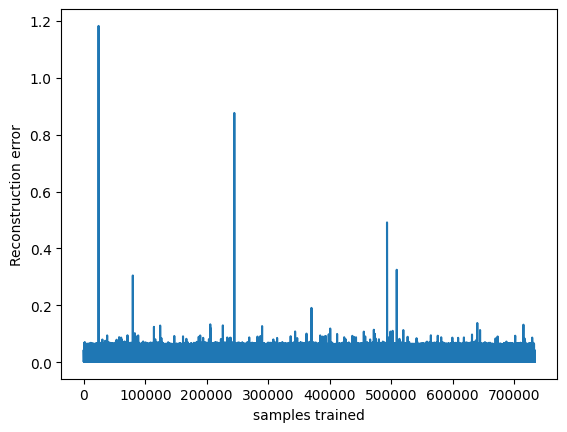

In [33]:
# Plot Reconstruction Loss

plt.plot(error_df.Reconstruction_error)
plt.xlabel('samples trained')
plt.ylabel('Reconstruction error')
plt.show()

In [34]:
# Getting Predictions from model and evaluating it's matrices.

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# actual attack column as a list
y_test_attack = pd.DataFrame(X_test)[30].to_list()

# predicted attack column as a list
y_pred_attack = pd.DataFrame(x_hat)[30].to_list()

# rounding the predicted attack column
y_pred_attack = list(map(round, y_pred_attack))

# Calculate accuracy
accuracy = accuracy_score(y_test_attack, y_pred_attack)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test_attack, y_pred_attack, average='binary')
print('At threshold:', 0.5)
print('Accuray:', accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

At threshold: 0.5
Accuray: 0.9998623424945994
Precision: 0.9998623424945994
Recall: 1.0
F1 Score: 0.9999311665095764


Confusion Matrix:




<Axes: >

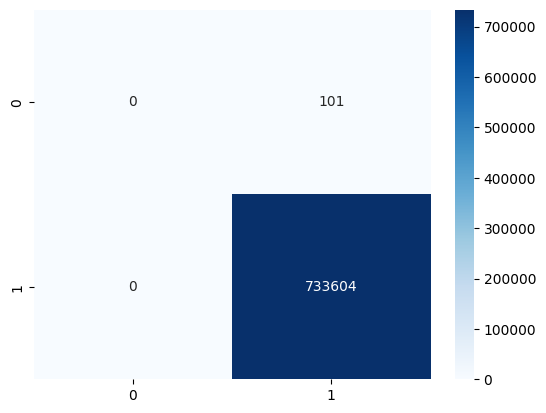

In [35]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_attack, y_pred_attack)
print("Confusion Matrix:\n\n", )

import seaborn as sns

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [36]:
mse_df = pd.DataFrame(mse)
mse_df.describe()

,0
count,733705.000000
mean,0.003200
std,0.006162
min,0.001200
25%,0.001604
50%,0.001863
75%,0.002809
max,1.182084


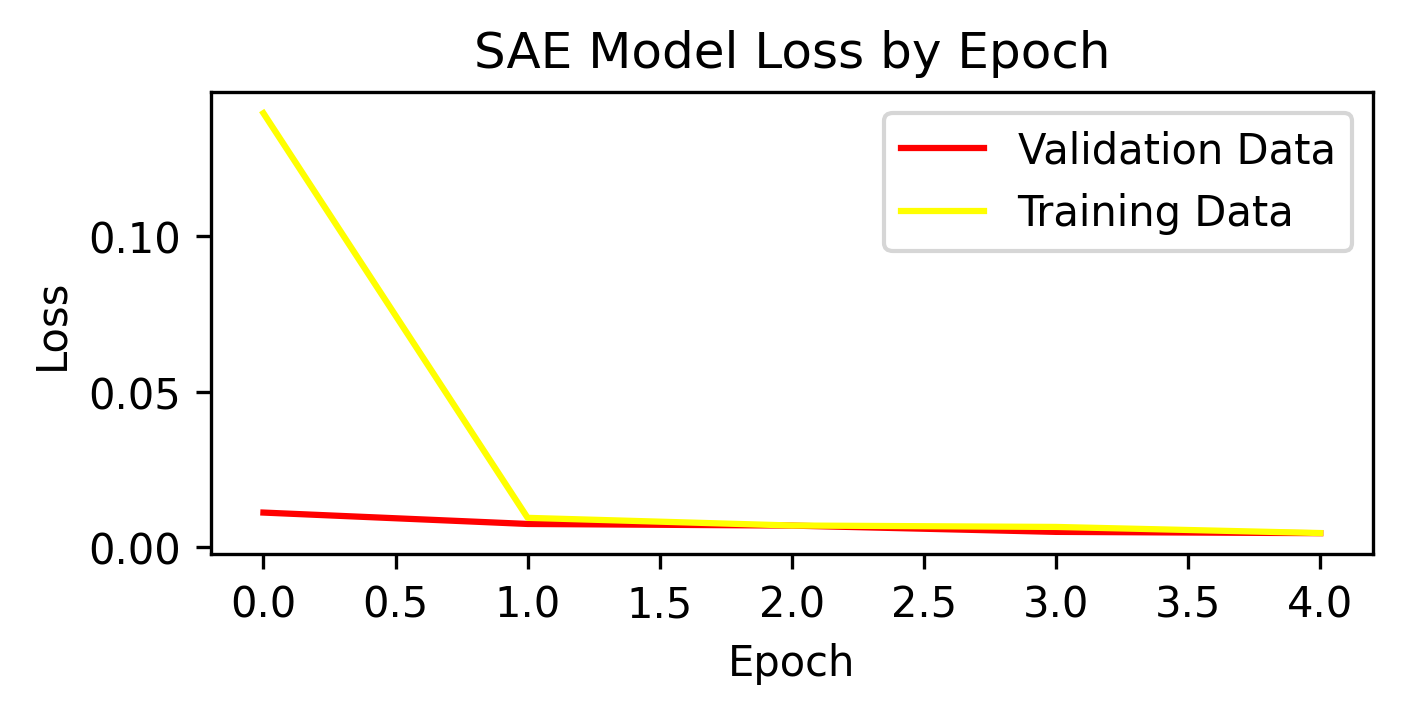

<Figure size 640x480 with 0 Axes>

In [37]:
Sfig, ax = plt.subplots(figsize=(5, 2), dpi=300)
plt.title(label='SAE Model Loss by Epoch', loc='center')
ax.plot(history['val_loss'], label='Validation Data', color='red')
ax.plot(history['loss'], label='Training Data', color='yellow')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()
plt.show()
plt.savefig('train_val_loss.png')

In [38]:
# Model Weights

import pprint
weights = SAE_model.get_weights()
pprint.pprint(weights)

[array([[ 3.54294926e-01,  4.36386763e-04,  1.45390281e-04,
        -0.00000000e+00,  3.67051980e-04,  4.61268122e-04,
        -0.00000000e+00,  7.11745088e-05, -0.00000000e+00,
        -0.00000000e+00,  2.88701704e-04,  1.04548701e-04,
         1.64333815e-05,  1.64126286e-05,  5.14509738e-04,
         2.12334658e-06,  4.05508210e-04, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00],
       [ 7.00017845e-04,  5.70088858e-04,  5.91892531e-05,
         3.69794034e-05,  5.37253625e-04,  5.96926431e-04,
        -0.00000000e+00,  7.45170619e-05, -0.00000000e+00,
         2.50370249e-06,  1.66834536e-04,  1.82609758e-04,
         1.06842148e-04,  6.90328656e-04,  7.11024390e-04,
         1.53359797e-05,  7.88012869e-04,  4.78809707e-05,
        -0.00000000e+00, -0.00000000e+00,  4.14651004e-06,
        -0.00000000e+00],
       [ 5.53178077e-04,  3.15139885e-04,  1.22740648e-05,
        -0.00000000e+00,  1.56966678e-04,  3.92474118e-04,
   